In [1]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.spatial import cKDTree
import open3d as o3d
from collections import defaultdict

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pc_seg.pc_label_map import color_map_dict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Invert the colormap to get RGB → label index
rgb_to_label = {tuple(v[0]): k for k, v in color_map_dict.items()}
label_to_name = {k: v[1] for k, v in color_map_dict.items()}

def get_label_from_color(color_array):
    """Match color to closest known semantic color label."""
    labels = []
    for c in color_array:
        # Round to 3 decimals to avoid float precision mismatch
        key = tuple(np.round(c, 3))
        label = rgb_to_label.get(key, -1)  # -1 if unmatched
        labels.append(label)
    return np.array(labels)

In [3]:
# Load the ground truch point cloud

#hexagon_path = r"C:\Users\yanpe\OneDrive - Metropolia Ammattikorkeakoulu Oy\Research\data\hexagon\Fira- 1001.ply"
smartlab_path = "../docs/SmartLab_2024_E57_Single_5mm_SEG_colors.ply"

gt_pcd = o3d.io.read_point_cloud(smartlab_path)   # ground truth point cloud with full resolution


In [11]:
o3d.visualization.draw_geometries([gt_pcd], point_show_normal=False)

In [4]:
def print_label_counts(label_array, name="Point Cloud"):
    print(f"\n📦 Label counts for {name}:")
    unique_labels, counts = np.unique(label_array, return_counts=True)
    total_points = len(label_array)
    for label, count in zip(unique_labels, counts):
        class_name = label_to_name.get(label, f"Class {label}")
        percentage = (count / total_points) * 100
        print(f"  {label:2d} ({class_name:10s}): {count:6d} points ({percentage:5.2f}%)")

In [5]:
# Move the point cloud to its min(x,y,z) corner
 
def move_to_corner(points):    
    # Find the minimum x, y, z
    min_xyz = points.min(axis=0)
    # Translate the point cloud so that the min corner becomes the origin
    moved_points = points - min_xyz
    
    return moved_points

moved_points = move_to_corner(np.array(gt_pcd.points))
gt_pcd.points = o3d.utility.Vector3dVector(moved_points)

In [6]:
# Extract point coordinates and colors
gt_points = np.asarray(gt_pcd.points)
gt_origin_colors = np.asarray(gt_pcd.colors)
gt_colors = np.round(gt_origin_colors, 1)

# Convert color to semantic labels
gt_labels = get_label_from_color(gt_colors)

In [7]:
# Ground Truth
print_label_counts(gt_labels, name="Ground Truth")

# Prediction
#print_label_counts(pred_labels, name="Prediction")


📦 Label counts for Ground Truth:
   0 (ceiling   ): 5701035 points (15.85%)
   1 (floor     ): 5167644 points (14.37%)
   2 (wall      ): 11348550 points (31.55%)
   4 (column    ): 173882 points ( 0.48%)
   5 (window    ): 549543 points ( 1.53%)
   6 (door      ): 1451390 points ( 4.04%)
   7 (table     ): 243330 points ( 0.68%)
   8 (chair     ):  99590 points ( 0.28%)
   9 (sofa      ): 190263 points ( 0.53%)
  11 (board     ): 488769 points ( 1.36%)
  12 (clutter   ): 10552776 points (29.34%)


In [10]:
def visualize_label_distribution(label_array, label_to_name, title="Label Distribution"):
    unique_labels, counts = np.unique(label_array, return_counts=True)
    total_points = len(label_array)
    
    labels = [label_to_name.get(label, f"Class {label}") for label in unique_labels]
    percentages = (counts / total_points) * 100

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts, color='skyblue')
    
    # Annotate percentage above each bar
    for bar, pct in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{pct:.1f}%', 
                 ha='center', va='bottom', fontsize=10)

    plt.title(title)
    plt.xlabel("Labels")
    plt.ylabel("Number of Points")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

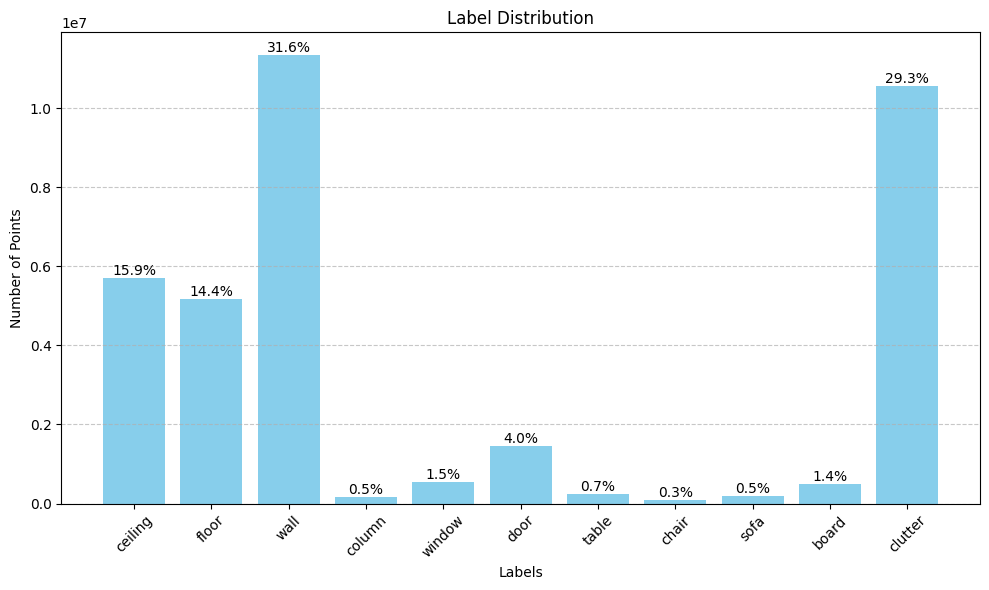

In [11]:
visualize_label_distribution(gt_labels, label_to_name)

In [17]:
def accuracy_per_class(gt_points,gt_labels,pred_file):
    results = []
    # Extract point coordinates and colors
    #gt_points = np.asarray(gt_pcd.points)
    #gt_origin_colors = np.asarray(gt_pcd.colors)
    #gt_colors = np.round(gt_origin_colors, 1)

    pred_pcd = o3d.io.read_point_cloud(pred_file[1])
    # Move points to the corner
    moved_pred_points = move_to_corner(np.array(pred_pcd.points))
    pred_pcd.points = o3d.utility.Vector3dVector(moved_pred_points)

    pred_points = np.asarray(pred_pcd.points)
    pred_origin_colors = np.asarray(pred_pcd.colors)
    pred_colors = np.round(pred_origin_colors, 1)    

    # Convert color to semantic labels
    #gt_labels = get_label_from_color(gt_colors)
    pred_labels = get_label_from_color(pred_colors)
    
    # Filter out unmatched labels (e.g. -1)
    valid_mask = (gt_labels != -1)
    gt_points = gt_points[valid_mask]
    gt_labels = gt_labels[valid_mask]

    # KDTree nearest neighbor matching
    tree = cKDTree(gt_points)
    _, indices = tree.query(pred_points, k=1)
    matched_pred_labels = gt_labels[indices]

    # Overall accuracy
    overall_accuracy = accuracy_score(pred_labels, matched_pred_labels)
    #print(f"\n✅ Overall Accuracy: {overall_accuracy:.3f}")
    results.append({
            "Model": pred_file[0],
            "Class": "Overall",
            "Accuracy": overall_accuracy
        })

    # Per-class accuracy
    #print("\n📋 Per-Class Accuracy:")
    class_counts = defaultdict(int)
    correct_counts = defaultdict(int)

    for true, pred in zip(pred_labels, matched_pred_labels):
        class_counts[true] += 1
        if true == pred:
            correct_counts[true] += 1

    for label in sorted(class_counts.keys()):
        correct = correct_counts[label]
        total = class_counts[label]
        acc = correct / total if total > 0 else 0.0
        class_name = label_to_name.get(label, f"Class {label}")
        #print(f"  {label:2d} ({class_name:10s}): {acc:.3f} ({correct}/{total})")

        results.append({
            "Model": pred_file[0],
            "Class": class_name,
            "Accuracy": acc
        })

    return results

In [13]:
pred_folder = "C:/Users/yanpe/OneDrive - Metropolia Ammattikorkeakoulu Oy/Research/data/smartlab/labelled/"

prediction_files = [
    ("S3DIS_Colors", pred_folder + "Smartlab_move2corner_label_pointnet2_x6_0.03_20250704.ply"),
    ("S3DIS_No_Colors", pred_folder + "Smartlab_move2corner_label_pointnet2_x3_0.03_20250704.ply"),
    ("Simulated","../docs/Smartlab_simulated_pretransform_label_pointnet2_x3_0.03_20250423.ply"),
    ("Simulated_finetuned","../docs/Smartlab_aalto_pcd_finetuned_label_pointnet2_x3_0.03_20250416.ply"),
    ("LoRA_finetuned","../docs/Smartlab_pcd_lora_label_pointnet2_x3_0.03_20250426.ply")
]

In [14]:
s3dis_files = [
    ("S3DIS_Colors_original", pred_folder + "Smartlab_original_label_pointnet2_x6_0.03_20250704.ply"),
    ("S3DIS_Colors_moved", pred_folder + "Smartlab_move2corner_label_pointnet2_x6_0.03_20250704.ply"),
    ("S3DIS_No_Colors_original", pred_folder + "Smartlab_original_label_pointnet2_x3_0.03_20250704.ply"),
    ("S3DIS_No_Colors_moved", pred_folder + "Smartlab_move2corner_label_pointnet2_x3_0.03_20250704.ply"),
]

In [17]:
'''hexagon_files = [
    ("Hexagon_Colors_original", pred_folder + "Hexagon_original_label_pointnet2_x6_0.03_20250704.ply"),
    ("Hexagon_Colors_moved", pred_folder + "Hexagon_move2corner_label_pointnet2_x6_0.03_20250704.ply"),
    ("Hexagon_No_Colors_original", pred_folder + "Hexagon_original_label_pointnet2_x3_0.03_20250704.ply"),
    ("Hexagon_No_Colors_moved", pred_folder + "Hexagon_move2corner_label_pointnet2_x3_0.03_20250704.ply")
]'''

In [18]:
results = []
for file in s3dis_files:
    results += accuracy_per_class(gt_points,gt_labels,file)


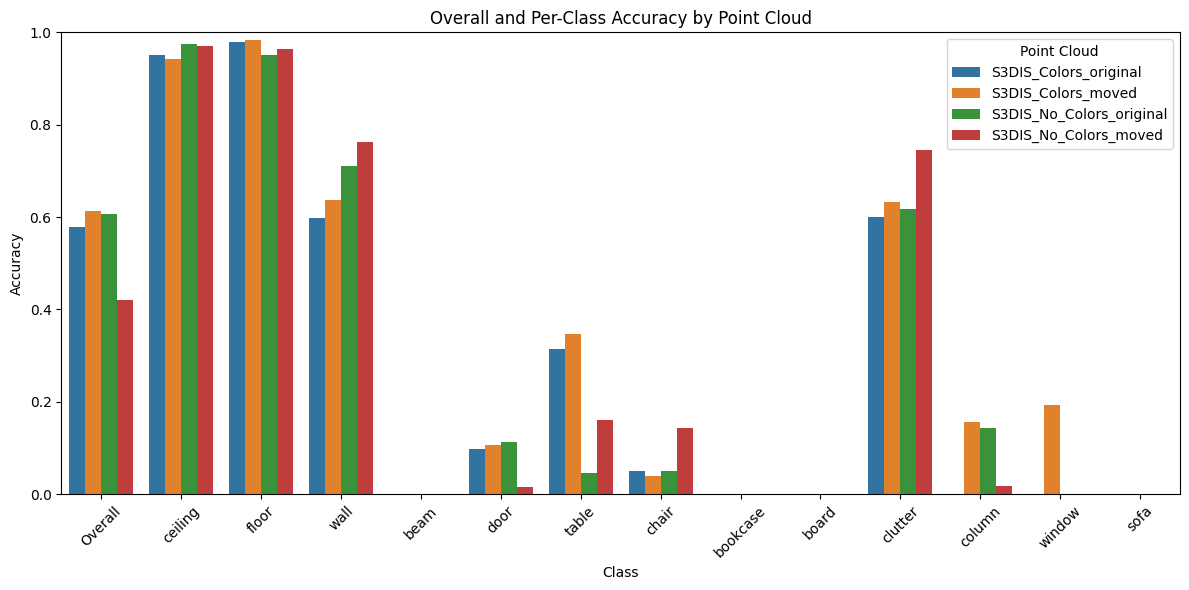

In [19]:
df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Class", y="Accuracy", hue="Model")
plt.title("Overall and Per-Class Accuracy by Point Cloud")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()


In [44]:
df.head()

,Model,Class,Accuracy
0,S3DIS_Colors,Overall,0.613871
1,S3DIS_Colors,ceiling,0.954771
2,S3DIS_Colors,floor,0.971747
3,S3DIS_Colors,wall,0.636541
4,S3DIS_Colors,beam,0.000000


In [8]:
# Compute the centroid
gt_centroid = gt_points.mean(axis=0)
pred_centroid = pred_points.mean(axis=0)

print(gt_centroid)
print(pred_centroid)

[5.25884302 5.6081679  1.74653798]
[5.20587027 5.64833263 1.76726065]


In [15]:
gt_min_xyz = gt_points.min(axis=0)
pred_min_xyz = pred_points.min(axis=0)

print(gt_min_xyz)
print(pred_min_xyz)

[-1.03750002 -4.06758022 -1.56200004]
[0.         0.00400019 0.00703452]


In [ ]:
# Classification report
# Ensure all labels used in GT or prediction are covered
all_labels = sorted(set(pred_labels) | set(matched_pred_labels))

print(classification_report(
    pred_labels,
    matched_pred_labels,
    labels=all_labels,
    target_names=[label_to_name.get(i, f"Class {i}") for i in all_labels]
))